inspiration:   
https://square.github.io/pysurvival/tutorials/maintenance.html

# Data cleaning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sksurv.metrics import concordance_index_censored
from sksurv.linear_model import CoxPHSurvivalAnalysis

### Basic descriptives

In [2]:
df=pd.read_csv('http://aws-proserve-data-science.s3.amazonaws.com/predictive_maintenance.csv')
print(df.shape)

(124494, 12)


In [3]:
# first few rows
df.head(2).T

,0,1
date,1/1/15,1/1/15
device,S1F01085,S1F0166B
failure,0,0
metric1,215630672,61370680
metric2,56,0
metric3,0,3
metric4,52,0
metric5,6,6
metric6,407438,403174
metric7,0,0


In [4]:
# except for the first two columns, all metrics are integers.
df.dtypes

date       object
device     object
failure     int64
metric1     int64
metric2     int64
metric3     int64
metric4     int64
metric5     int64
metric6     int64
metric7     int64
metric8     int64
metric9     int64
dtype: object

### Hypotheses about the data:

* one reading every day, per device
* no more than one reading per day, per device
* most devices start on the same day (Jan 1st)
* there are no devices with two failure records (each device can only fail once)
* once a failure happens, device is removed from service
* some models never fail during the observation period (censoring)

### Data cleaning

In [5]:
# There is no obvious missing data in any variable.
df.isnull().sum()

date       0
device     0
failure    0
metric1    0
metric2    0
metric3    0
metric4    0
metric5    0
metric6    0
metric7    0
metric8    0
metric9    0
dtype: int64

In [6]:
# metrics 7 and 8 are identical. Drop one of them.
print('correlation:', df['metric7'].corr(df['metric8']))
print ('Are there any rows where 7!=8?', False in list(df['metric7']==df['metric8']))
df=df.drop('metric8', axis=1)
print(df.shape)

correlation: 0.9999999999999999
Are there any rows where 7!=8? False
(124494, 11)


In [7]:
# There is only one instance of a duplicated device-date pair.
print('How many devices have 2 measurements in one day?', df[['device', 'date']].duplicated().sum())
# what is that row?
print(df[df[['device', 'date']].duplicated()==True][['device', 'date']])
df.loc[(df['device']=='S1F0R4Q8') & (df['date']=='2015-07-10')]

How many devices have 2 measurements in one day? 1
          device     date
101335  S1F0R4Q8  7/10/15


,date,device,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric9


In [8]:
# we should remove one of these duplicate rows.
df=df.drop(df.index[101335], axis=0)
df.reset_index(drop=True)
df.shape

(124493, 11)

In [9]:
# The dates are coded as strings. Replace this.
print(df['date'].dtype)
df['date']=pd.to_datetime(df['date'],infer_datetime_format=True)
df['date'].dtype

object


dtype('<M8[ns]')

In [10]:
# metric 1 appears to be an entirely random signal. remove it.
df['metric1'].describe()
df=df.drop('metric1', axis=1)

In [11]:
# what percentage of each is a zero? very high.
def lotsa_zeroes(col):
    numerator=len(df.loc[df[col]==0])
    denominator=len(df[col])
    print(col+':', round(numerator/denominator, 2))
for i in [2, 3,4,7]:
    lotsa_zeroes('metric'+str(i))

metric2: 0.95
metric3: 0.93
metric4: 0.92
metric7: 0.99


### Censoring
What is censoring? One of the challenges specific to survival analysis is that only some individuals will have experienced the event by the end of the study, and therefore survival times will be unknown for a subset of the study group. This phenomenon is called censoring

In [12]:
# How many unique devices are there?
df['device'].nunique()

1169

In [13]:
# Do all of them experience failure? Most do not.
df.groupby('device').max()['failure'].value_counts()

0    1063
1     106
Name: failure, dtype: int64

In [14]:
# Do any fail multiple times? No.
df.groupby('device').sum()['failure'].value_counts()

0    1063
1     106
Name: failure, dtype: int64

For the most part, when a device fails it is removed. A few devices (5) continue after they're dead.

In [15]:
# confirm that there are no devices with two failure records (each device only fails once)
dffailed=df.loc[df['failure']==1]
assert dffailed['device'].nunique()==dffailed.shape[0]

In [16]:
# restrict to the date on which a device failed.
deaddevice=df[df['failure']==1][['device','date']]

In [17]:
# merge the deathdates back into the regular dataset.
deaddevice = deaddevice.rename(columns={'date': 'deathdate'})
df=pd.merge(df, deaddevice, on='device', how='outer')
df.shape

(124493, 11)

In [18]:
# confirm that, for failed devices, there are no entries later than the failure date.
devices=df.groupby('device').max().reset_index(drop=False)
dead_devices=devices.loc[devices['failure']==1]
dead_devices=dead_devices.rename(columns={'date': 'maxdate'})
dead_devices=dead_devices[['device', 'maxdate', 'deathdate']]
dead_devices.loc[dead_devices['maxdate']!=dead_devices['deathdate']]

,device,maxdate,deathdate
101,S1F0GPFZ,2015-07-24,2015-07-12
504,S1F136J0,2015-05-06,2015-05-05
599,W1F0KCP2,2015-05-11,2015-05-09
625,W1F0M35B,2015-05-11,2015-05-09
819,W1F11ZG9,2015-08-17,2015-07-18


In [19]:
# For those 5 devices, remove any dates that occur after the failure.
zombies=dead_devices.loc[dead_devices['maxdate']!=dead_devices['deathdate']]['device']
print('Number of rows removed:', df.loc[(df['device'].isin(zombies)) & (df['date']>df['deathdate'])].shape[0])
print(df.shape[0])
df=df.loc[~((df['device'].isin(zombies)) & (df['date']>df['deathdate']))]
print(df.shape[0])
df=df.drop(['deathdate'], axis=1)

Number of rows removed: 47
124493
124446


## Feature engineering by device ID

In [20]:
# What's the first date in the series?
print(df['date'].min())
# Do all devices start on this same date? No.
bydevice=df.groupby('device')['date', 'failure'].min().reset_index(drop=False)
bydevice['date'].value_counts()

2015-01-01 00:00:00


<ipython-input-20-b6a43f308e88>:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  bydevice=df.groupby('device')['date', 'failure'].min().reset_index(drop=False)


2015-01-01    1163
2015-05-06       4
2015-06-13       1
2015-01-27       1
Name: date, dtype: int64

In [21]:
# creates new dataframe: one row for each device (reduces dimensions from 124K to 1163)
dfmin=df.groupby('device').min().reset_index(drop=False)
# same, but for max values
dfmax=df.groupby('device').max().reset_index(drop=False)

dfmin.head(2)

,device,date,failure,metric2,metric3,metric4,metric5,metric6,metric7,metric9
0,S1F01085,2015-01-01,0,56,0,52,6,407438,0,7
1,S1F013BB,2015-05-06,0,0,0,0,5,688952,0,0


Visualize a single device.

While the metrics are important, they are also not constant by device - they change over time. This calls for a time-series analysis. For the purpose of Cox regression, let's remove and focus only on device type (prefix).

In [22]:
# which metrics tend to change within a device? all of them.
dfcompare=pd.merge(dfmax, dfmin, on='device', how='left')
dfcompare['metric2_z']=dfcompare['metric2_x']-dfcompare['metric2_y']
dfcompare['metric3_z']=dfcompare['metric3_x']-dfcompare['metric3_y']
dfcompare['metric4_z']=dfcompare['metric4_x']-dfcompare['metric4_y']
dfcompare['metric5_z']=dfcompare['metric5_x']-dfcompare['metric5_y']
dfcompare['metric6_z']=dfcompare['metric6_x']-dfcompare['metric6_y']
dfcompare['metric7_z']=dfcompare['metric7_x']-dfcompare['metric7_y']
dfcompare['metric9_z']=dfcompare['metric9_x']-dfcompare['metric9_y']
for var in ['metric2_z','metric3_z','metric4_z','metric5_z','metric6_z','metric7_z','metric9_z']:
    print(str(var), dfcompare[var].mean())
# this suggests that metrics change, and are an indicator of health.

metric2_z 633.0675791274593
metric3_z 2.223267750213858
metric4_z 6.098374679213003
metric5_z 0.4679213002566296
metric6_z 31298.350727117195
metric7_z 4.076988879384089
metric9_z 0.1787852865697177


In [23]:
# just focus on the date for now. Create a column indicating the minimum date, for each device.
dfmin=dfmin[['device', 'date']]
dfmin.rename(columns={'date':'mindate'},inplace=True)
print(dfmin.shape)
dfmin.head()

(1169, 2)


,device,mindate
0,S1F01085,2015-01-01
1,S1F013BB,2015-05-06
2,S1F0166B,2015-01-01
3,S1F01E6Y,2015-01-01
4,S1F01JE0,2015-01-01


In [24]:
# We can group devices into 7 categories based on their device ID code
dfmin['prefix']=dfmin['device'].apply(lambda row: row[:4])
dfmin['prefix'].value_counts()

S1F0    391
W1F0    282
Z1F0    149
S1F1    139
W1F1    138
Z1F1     67
Z1F2      3
Name: prefix, dtype: int64

In [25]:
# merge the groupby-dataset back into primary the dataset
print(df.shape)
df=pd.merge(df, dfmin, on='device', how='left')

(124446, 10)


In [26]:
# create a column to measure elapsed time.
df['timelapse']=(df['date']-df['mindate']).dt.days
df['timelapse'].value_counts()

0      1169
1      1168
2      1168
3      1167
4      1166
       ... 
302      31
303      31
301      31
305      31
299      31
Name: timelapse, Length: 304, dtype: int64

In [69]:
# one-hot encoding of device prefix
ohe=pd.get_dummies(df['prefix'])
df=pd.concat([df, ohe],axis=1)
df.drop(['prefix'],axis=1)
df.head()

,date,device,failure,metric2,metric3,metric4,metric5,metric6,metric7,metric9,mindate,prefix,timelapse,S1F0,S1F1,W1F0,W1F1,Z1F0,Z1F1,Z1F2
0,2015-01-01,S1F01085,0,56,0,52,6,407438,0,7,2015-01-01,S1F0,0,1,0,0,0,0,0,0
1,2015-01-02,S1F01085,0,56,0,52,6,407438,0,7,2015-01-01,S1F0,1,1,0,0,0,0,0,0
2,2015-01-03,S1F01085,0,56,0,52,6,407438,0,7,2015-01-01,S1F0,2,1,0,0,0,0,0,0
3,2015-01-04,S1F01085,0,56,0,52,6,407439,0,7,2015-01-01,S1F0,3,1,0,0,0,0,0,0
4,2015-01-05,S1F01085,0,56,0,52,6,408114,0,7,2015-01-01,S1F0,4,1,0,0,0,0,0,0


In [27]:
# What's the longest-lived device that failed?
print(df['timelapse'].max())
df.loc[(df['timelapse']>=280) & (df['failure']==1)]['device'].unique()
T0B1=df.loc[df['device']=='W1F0T0B1']

305


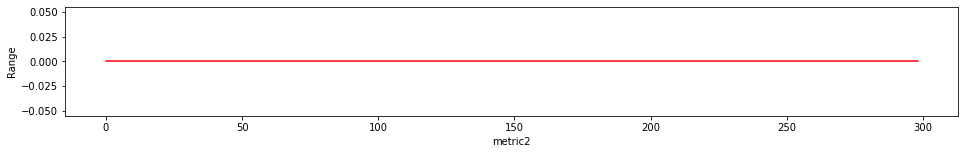

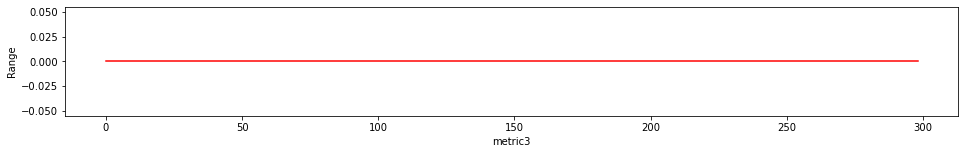

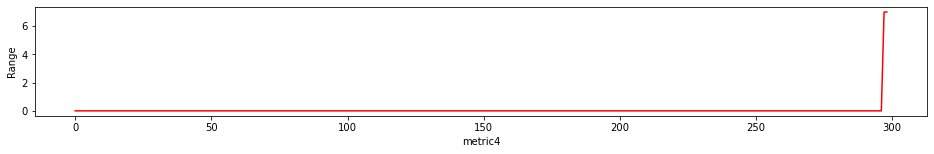

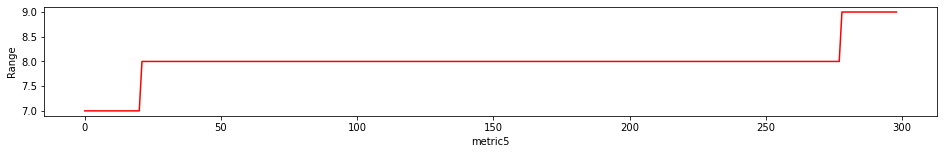

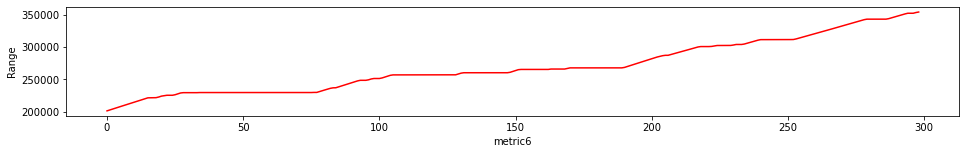

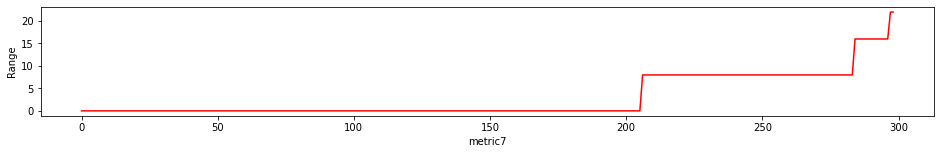

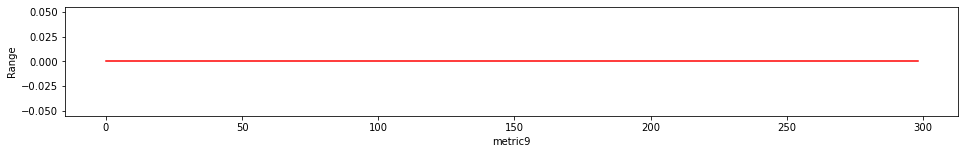

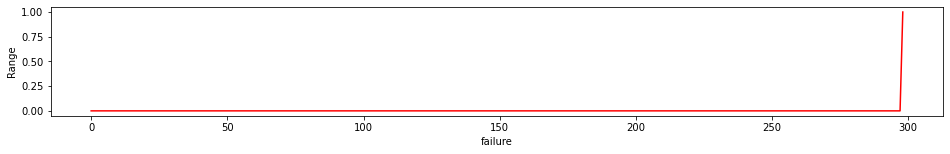

In [28]:
# display the metrics for one device
metrics=['metric2','metric3','metric4','metric5','metric6','metric7','metric9','failure']
for num in range(len(metrics)):
    plt.figure(figsize=(16,2))
    plt.plot(T0B1['timelapse'], T0B1[metrics[num]], color = 'r')
    plt.xlabel(metrics[num])
    plt.ylabel("Range")
    plt.show()

## Modeling

In [82]:
# make a list of features
features = ['metric2', 'metric3', 'metric4', 'metric5', 'metric6', 'metric7',
            'metric9','S1F0', 'S1F1', 'W1F0', 'W1F1', 'Z1F0', 'Z1F1', 'Z1F2']
features = ['metric6']

In [83]:
# randomly select device ID numbers for train-test split
import random
device_ids=list(df['device'].unique())
test_size=int(len(device_ids)*.4)
print(test_size)
test_list = random.sample(device_ids, test_size)
print(test_list[:5])

467
['Z1F0LSXW', 'Z1F19VF5', 'Z1F147WQ', 'Z1F0LJTD', 'Z1F0MYEL']


In [84]:
# train-test split
data_test = df[df['device'].isin(test_list)]
data_train = df[~df['device'].isin(test_list)]
print(len(df))
print(len(data_train))
print(len(data_test))
assert len(data_train)+len(data_test)==len(df)

124446
76849
47597


In [85]:
# Creating the X, T and E inputs
X_train, X_test = data_train[features], data_test[features]
T_train, T_test = data_train['timelapse'], data_test['timelapse']
E_train, E_test = data_train['failure'], data_test['failure']

The Multi-Task Logistic Regression (MTLR) model is an alternative to the Cox’s proportional hazard model. It can be seen as a series of logistic regression models built on different time intervals so as to estimate the probability that the event of interest happened within each interval.

In [86]:
# Let's now fit a Linear MTLR model to the training set. 
from pysurvival.models.multi_task import LinearMultiTaskModel

# Initializing the MTLR with a time axis split into 300 intervals
linear_mtlr = LinearMultiTaskModel(bins=300)

# Fitting the model
linear_mtlr.fit(X_train, T_train, E_train, num_epochs = 1000,
                init_method = 'orthogonal', optimizer ='rmsprop',
                lr = 1e-3, l2_reg = 3,  l2_smooth = 3, )


KeyboardInterrupt: 

In [ ]:
from pysurvival.utils.display import display_loss_values
display_loss_values(linear_mtlr, figure_size=(7, 4))